In [74]:
import cv2 as cv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [75]:
from midas.run import process, load_model
from midas.utils import read_image
# require timm==0.6.12
# or the state dict won't load (why?)
# https://github.com/isl-org/MiDaS/blob/bdc4ed64c095e026dc0a2f17cabb14d58263decb/environment.yaml#L15C7-L15C19


In [85]:
from pathlib import Path
MODEL_PATH = "dpt_swin2_tiny_256.pt"
VIDEO_PATH = "rotated.avi"
OUTPUT_PATH = "output.avi"
video_path = Path(VIDEO_PATH)
model_path = Path(MODEL_PATH)
output_path = Path(OUTPUT_PATH)
assert video_path.exists(), f"Video file does not exist at {video_path}"
assert model_path.exists(), f"Model file does not exist at {model_path}"

In [77]:
# device = torch.device("cpu") # use CPU intentionally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimize=False
side=False
height=None
square=False
grayscale=False
model_type = "dpt_swin2_tiny_256"
model, transform, net_w, net_h = load_model(device, MODEL_PATH, model_type, optimize, height, square)
print("device: {} model_type: {}".format(device, model_type))

Model loaded, number of parameters = 42M
device: cuda model_type: dpt_swin2_tiny_256


In [78]:
cap = cv.VideoCapture(VIDEO_PATH)
fps = cap.get(cv.CAP_PROP_FPS)
w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
all_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
at_frame = 60
assert at_frame < all_frames
cap.set(cv.CAP_PROP_POS_FRAMES, at_frame)
display("{}x{} @ {} FPS ({}/{})".format(w, h, fps, at_frame, all_frames))
ret, frame = cap.read()
# writer = cv.VideoWriter(OUTPUT_PATH, cv.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
if ret == True:
  if frame.ndim == 2:
      frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
  frame = cv2.normalize(frame, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
assert ret == True
cap.release()

'1280x720 @ 30.0 FPS (60/893)'

    Input resized to 256x256 before entering the encoder


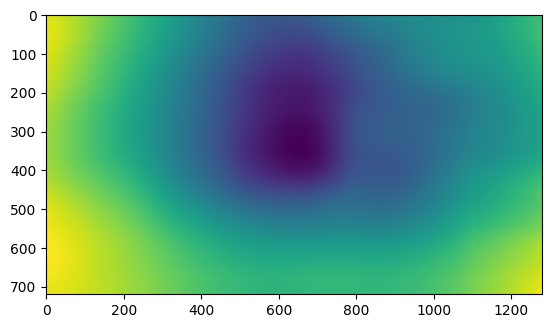

In [79]:
img = frame
img_size = img.shape[1::-1]
resized = transform({"image": img/255})["image"]
uint8_max = np.iinfo(np.uint8).max
with torch.no_grad():
  depth = process(device, model, model_type, resized, (net_w, net_h), img_size, optimize, False)
mask = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(mask)

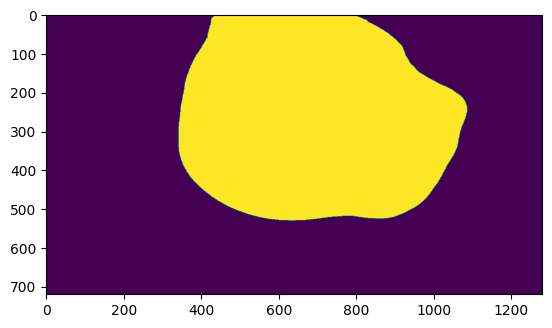

In [80]:
masked = img.copy()
u8_mask = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
inverted = cv2.bitwise_not(u8_mask)
ret, limited = cv2.threshold(inverted, 150, 255, cv.THRESH_BINARY)
f32_mask = cv2.normalize(limited, None, 0.0, 1.0, cv2.NORM_MINMAX, cv2.CV_32F)
img_f32 = img.astype(np.float32)
rgba = cv2.cvtColor(img_f32, cv2.COLOR_RGB2RGBA)
rgba = cv2.normalize(rgba, None, 0.0, 1.0, cv2.NORM_MINMAX, cv2.CV_32F)
rgba[:, :, 3] = f32_mask
plt.imshow(limited)

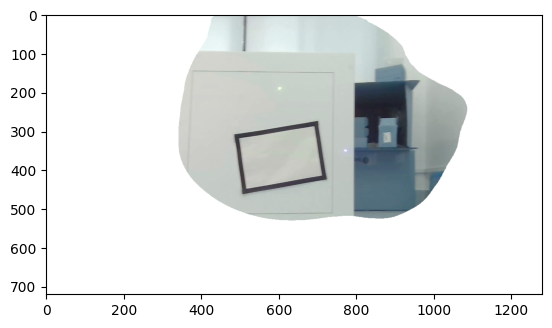

In [81]:
plt.imshow(rgba)

In [82]:
depth_max = np.max(depth)
depth_min = np.min(depth)
display("max {} min {}".format(depth_max, depth_min))

'max 1446.205810546875 min 842.032470703125'

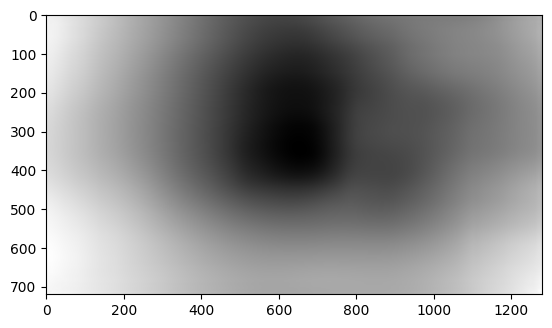

In [83]:
uint8_max = np.iinfo(np.uint8).max
normalized = cv2.normalize(depth, None, 0, uint8_max, cv2.NORM_MINMAX).astype(np.uint8)
converted = cv2.cvtColor(normalized, cv2.COLOR_GRAY2BGR)
plt.imshow(converted)

In [88]:
is_save_video = True
if is_save_video:
  # write to video
  cap = cv.VideoCapture(VIDEO_PATH)
  fps = cap.get(cv.CAP_PROP_FPS)
  w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
  h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
  display("{}x{} @ {} FPS".format(w, h, fps))
  writer = cv.VideoWriter(OUTPUT_PATH, cv.VideoWriter_fourcc(*'MJPG'), fps, (w, h))
  while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
      break
    if frame.ndim == 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
    img = frame
    img_size = img.shape[1::-1]
    resized = transform({"image": img/255})["image"]
    with torch.no_grad():
      depth = process(device, model, model_type, resized, (net_w, net_h), img_size, optimize, False)
      uint8_max = np.iinfo(np.uint8).max
      normalized = cv2.normalize(depth, None, 0, uint8_max, cv2.NORM_MINMAX).astype(np.uint8)
      converted = cv2.cvtColor(normalized, cv2.COLOR_GRAY2BGR)
      img = frame
      u8_mask = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
      inverted = cv2.bitwise_not(u8_mask)
      ret, limited = cv2.threshold(inverted, 150, 255, cv.THRESH_BINARY)
      f32_mask = cv2.normalize(limited, None, 0.0, 1.0, cv2.NORM_MINMAX, cv2.CV_32F)
      f32_mask_3chan = np.repeat(f32_mask[:, :, np.newaxis], 3, axis=2)
      masked = img * f32_mask_3chan
      writer.write(masked)
  writer.release()

'1280x720 @ 30.0 FPS'

    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 before entering the encoder
    Input resized to 256x256 be

KeyboardInterrupt: 